In [65]:
import os
import math
import optparse
import time
import sys
import numpy as np
from scipy.stats import expon
from scipy.stats import poisson
from scipy import stats  
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
import root_numpy as rn
import ROOT as rt


from time import perf_counter
import gc

#energyDep_hit = 6 #keV
ion_pot = 0.0462 #keV
#GEM_gain = 123
GEM1_HV = 440
GEM2_HV = 440
GEM3_HV = 440

GEM1_gain = 0.0347*np.exp((0.0209)*GEM1_HV) #400 #330
GEM2_gain = 0.0347*np.exp((0.0209)*GEM2_HV) #400 #330
GEM3_gain = 0.0347*np.exp((0.0209)*GEM3_HV) #400 #330

extraction_eff = 0.37

## from https://arxiv.org/pdf/2007.00608.pdf field 0.5 kV/cm
diff_const_sigma0T = 0.0784  # diffusion constant [mm]^2
diff_coeff_T = 0.0196        # diffusion parameter [mm/sqrt(cm)]^2
diff_const_sigma0L = 0.0676
diff_coeff_L = 0.0144



x_dim = 350 #mm
y_dim = 350 #mm
x_pix = 2304
y_pix = 2304
z_vox_dim = 0.1 #mm

sensor_size = 14.976 #mm
camera_aperture = 0.95

photons_per_el = 0.07
counts_per_photon = 2
demag=y_dim/sensor_size
a=camera_aperture
omega=1./math.pow((4*(demag+1)*a),2)   # solid angle ratio
print("omega = %f"% omega)

A = 1.
beta = 0.5e-5
absorption_l = 1000 #mm

saturation = 1
 

print("Opening file /home/giulia/Physics/CYGNO/gain/CYGNO_60_40_ER_30_keV_part0.root")
inputfile = rt.TFile.Open("/home/giulia/Physics/CYGNO/gain/CYGNO_60_40_ER_30_keV_part0.root")
tree = inputfile.Get("nTuple")

def NelGEM2(energyDep,z_hit):
    n_ioniz_el=(energyDep/ion_pot)
    drift_l = np.abs(z_hit-z_gem)
    #print("distance from the gem %d mm"%drift_l)
    n_ioniz_el_mean = n_ioniz_el*np.exp(-drift_l/absorption_l) 
    primary=poisson(n_ioniz_el_mean)           # poisson distribution for primary electrons
    n_ioniz_el=primary.rvs()                   # number of primary electrons
    #n_ioniz_el=n_ioniz_el_mean
    #n_ioniz_el_array = np.append(n_ioniz_el_array,n_ioniz_el)
    #print('n ionization electrons = %d'%(n_ioniz_el))
    n_el_oneGEM=0                              # number of secondary electrons
    gain1=expon(loc=0,scale=GEM1_gain)  # exponential distribution for the GAIN in the first GEM foil
    for k in range(0,n_ioniz_el):
        nsec = gain1.rvs()*extraction_eff      # number of secondary electrons in the first GEM multiplication for each ionization electron
        n_el_oneGEM += nsec
        #nsec_1GEM_array = np.append(nsec_1GEM_array,nsec)
        #print ('--   loop on ioniz el, k= %d - nsec= %d - nel_onegem= %d'%(k,nsec,n_el_oneGEM))

    # total number of secondary electrons considering the gain in the 2nd GEM foil
    n_tot_el=n_el_oneGEM*GEM2_gain*extraction_eff
    #print("Electrons after 2nd GEM: %d"%n_tot_el)


    return n_tot_el

def cloud_smearing3D(x_hit,y_hit,z_hit,energyDep_hit):
    X=list(); Y=list(); Z=list() 
    X*=0; Y*=0; Z*=0
    nel=NelGEM2(energyDep_hit,z_hit)

    ## arrays of positions of produced electrons after GEM2
    X=(np.random.normal(loc=(x_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nel)))
    Y=(np.random.normal(loc=(y_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nel)))
    Z=(np.random.normal(loc=(z_hit-z_ini), scale=np.sqrt(diff_const_sigma0L+diff_coeff_L*(np.abs(z_hit-z_gem))/10.), size=int(nel)))   
    #print("distance from the GEM : %f cm"%((np.abs(z_hit-z_gem))/10.))
    #print(Z)
    return X, Y, Z

def ph_smearing2D(x_hit,y_hit,z_hit,energyDep_hit):
    X=list(); Y=list()
    X*=0; Y*=0
    ## electrons in GEM2
    nel = NelGEM2(energyDep_hit,z_hit)
    ## photons in GEM3
    nph = nel * GEM3_gain *omega * photons_per_el * counts_per_photon
    ## arrays of positions of produced photons
    X=(np.random.normal(loc=(x_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nph)))
    Y=(np.random.normal(loc=(y_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nph)))
    return X, Y

    
def Nph_saturation(histo_cloud):
    Nph_array = np.zeros((histo_cloud.GetNbinsX(),histo_cloud.GetNbinsY()))
    Nph_tot = 0
    for i in range(1100,1400):
        for j in range(1100,1400):
            hout = 0
            for k in range(1,histo_cloud.GetNbinsZ()+1):
                hin = histo_cloud.GetBinContent(i,j,k)
                #electrons = poisson(hin)
                #nel_in = electrons.rvs() 
                nel_in = hin
                #if nel_in==0:
                #    continue
                #else:
                #print("number initial electrons per voxel input: %d"%nel_in)
                ## sum voxels along z
                #gain3=expon(loc=0,scale=GEM_gain)  # exponential distribution for the GAIN of 3rd GEM
                #gain_rnd = gain3.rvs()     
                #print("gain extracted = %d"%gain_rnd)
                #if nel_in>0:
                #    print("number initial electrons per voxel input: %d"%nel_in)
                #    print("number final electrons per voxel: %f"%((nel_in * A * GEM3_gain)/(1 + beta * GEM3_gain  * nel_in) ))
                #    print("number final electrons per voxel without saturation: %f"%(nel_in * A * GEM3_gain ))

                hout += (nel_in * A * GEM3_gain)/(1 + beta * GEM3_gain  * nel_in) 
                #print(1 + beta * GEM_gain  * nel_in)
                #hout += (nel_in * A * gain_rnd)/(1 + beta * gain_rnd  * nel_in) 

            nmean_ph= hout * omega * photons_per_el * counts_per_photon     # mean total number of photons
            photons=poisson(nmean_ph)                    # poisson distribution for photons
            n_ph=photons.rvs()  
            Nph_array[i-1][j-1] = n_ph
            Nph_tot += Nph_array[i-1][j-1]
            
            
    return Nph_tot, Nph_array




omega = 0.000117
Opening file /home/giulia/Physics/CYGNO/gain/CYGNO_60_40_ER_30_keV_part0.root


In [40]:
maxentries = 1
zcloud = 20 #mm
zbins = int(zcloud/z_vox_dim)

z_ini = 255.
z_gem = 455. #mm

print("n voxels z : %d" %zbins)


#nph_array = np.zeros(tree.GetEntries())
nph_array = np.zeros(maxentries)
nph_nosat = np.zeros(maxentries)

#for iev in range(0,tree.GetEntries()):
for iev in range(0,maxentries):
    t1_start = perf_counter() 

    tree.GetEntry(iev)
    if (iev%10==0): 
        print("Processing event %d"%iev)
    numhits = tree.numhits

    histname = "histo_cloud_pic_"+str(int(iev)) 
    histo_cloud = rt.TH3I(histname,"",x_pix,0,x_pix-1,y_pix,0,y_pix-1,zbins,0,zbins)
    #histo_cloud_draw = rt.TH2I("histoclouddraw"+str(int(iev)),"",60,1120,1180,60,1120,1180) #100,0,100)

    #print("created histo_cloud")
    
    ## with saturation
    if (saturation>0):
        tot_el_G2 = 0
        for ihit in range(0,tree.numhits):
            #print("Processing hit %d of %d"%(ihit,tree.numhits))

            ## here swapping X with Z beacuse in geant the drift axis is X
            S3D = cloud_smearing3D(tree.z_hits[ihit],tree.y_hits[ihit],tree.x_hits[ihit],tree.energyDep_hits[ihit])

            for j in range(0, len(S3D[0])):
                #print((0.5*x_dim+S3D[0][j])*x_pix/x_dim)
                histo_cloud.Fill((0.5*x_dim+S3D[0][j])*x_pix/x_dim, (0.5*y_dim+S3D[1][j])*y_pix/y_dim, (0.5*zcloud+S3D[2][j])*zbins/zcloud ) 
                
                #histo_cloud_draw.Fill((0.5*x_dim+S3D[0][j])*x_pix/x_dim,(0.5*y_dim+S3D[1][j])*y_pix/y_dim) # (0.5*histo_cloud.GetNbinsZ()*z_vox_dim+S3D[2][j])/z_vox_dim)    
                tot_el_G2+=1
                
        #tot_el_G2 = histo_cloud.Integral()
    
        # 2d map of photons applying saturation effect
        result_GEM3 = Nph_saturation(histo_cloud)
        array2d_Nph = result_GEM3[1]
        tot_ph_G3 = result_GEM3[0] #np.sum(array2d_Nph)

        print("tot num of sensor counts after GEM3 including saturation: %d"%(tot_ph_G3))
        print("tot num of sensor counts after GEM3 without saturation: %d"%(A*tot_el_G2*GEM3_gain* omega * photons_per_el * counts_per_photon))
        print("Gain GEM3 = %f   Gain GEM3 saturated = %f"%(GEM3_gain, tot_ph_G3/(tot_el_G2*omega * photons_per_el * counts_per_photon) ))   

    ## no saturation
    else:
        tot_ph_G3=0
        for ihit in range(0,tree.numhits):
            ## here swapping X with Z beacuse in geant the drift axis is X
            S2D = ph_smearing2D(tree.z_hits[ihit],tree.y_hits[ihit],tree.x_hits[ihit],tree.energyDep_hits[ihit])
            
            #for j in range(0, len(S2D[0])):
            for t in range(0, len(S2D[0])):
                tot_ph_G3+=1

        #print("tot num of sensor counts after GEM3 without saturation: %d"%(tot_ph_G3))

       

    nph_array[iev] = tot_ph_G3
    nph_nosat[iev] = tot_el_G2*GEM3_gain* omega * photons_per_el * counts_per_photon
    t1_stop = perf_counter() 
    
    print("Time event %d s"%(t1_stop-t1_start))

n voxels z : 200
Processing event 0
tot num of sensor counts after GEM3 including saturation: 27923
tot num of sensor counts after GEM3 without saturation: 42866
Gain GEM3 = 342.059401   Gain GEM3 saturated = 222.815152
Time event 88 s


created final_image


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


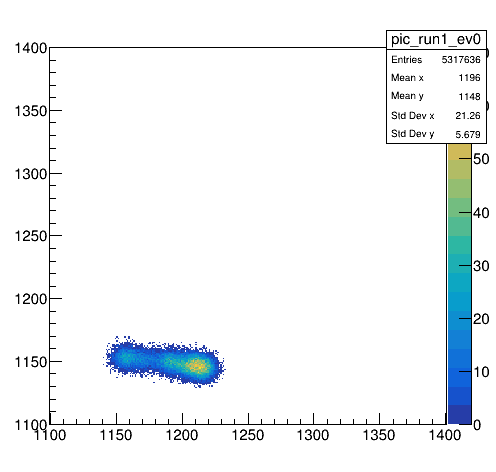

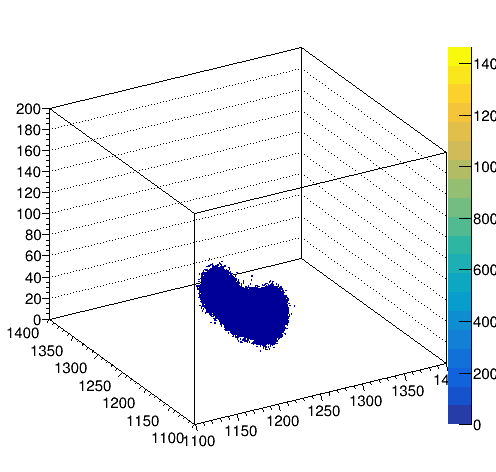

In [41]:
rt.gStyle.SetCanvasPreferGL(1);

## create final image
final_image=rt.TH2I('pic_run1_ev'+str(iev), '', x_pix, 0, x_pix-1, y_pix, 0, y_pix-1)
print("created final_image")
final_image=rn.array2hist(array2d_Nph, final_image)
    
c = rt.TCanvas("c","",500,500)
final_image.GetXaxis().SetRangeUser(1100,1400)
final_image.GetYaxis().SetRangeUser(1100,1400)

final_image.Draw("colz")
c.Draw()

c2 = rt.TCanvas("c2","",500,500)
histo_cloud.GetXaxis().SetRangeUser(1100,1400)
histo_cloud.GetYaxis().SetRangeUser(1100,1400)
histo_cloud.GetZaxis().SetRangeUser(0,zbins)
hX = histo_cloud.ProjectionX()

histo_cloud.Draw("box2z")
#hX.Draw()
c2.Draw()

/home/giulia/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


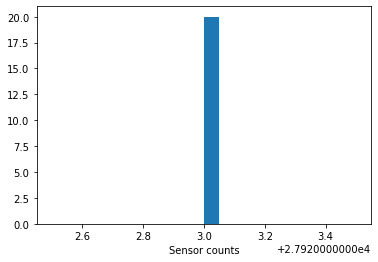

mean = 27923, sigma = 0, resolution = 0.000000


In [42]:
  

#fig, ax = plt.subplots()
num_bins = 20

## the histogram of the data
##n, bins, patches = ax.hist(nph_array, num_bins, density=True)
plt.hist(nph_array, num_bins, density=True)

# best fit of data
m, s = stats.norm.fit(nph_array) # get mean and standard deviation  
xmin, xmax = min(nph_array), max(nph_array)  
lnspc = np.linspace(xmin, xmax, len(nph_array))
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it


## Tweak spacing to prevent clipping of ylabel
##fig.tight_layout()array2d_NelGEM3

plt.xlabel('Sensor counts')
plt.ylabel('')
plt.show()

print("mean = %d, sigma = %d, resolution = %f"%(m,s,s/m))



##print(nsec_1GEM_array)
#plt.hist(nsec_1GEM_array,num_bins, density=True)
##plt.xlim(xmin=0, xmax = 1000)
##plt.ylim(ymin=0, ymax = 10000)
#EXP = expon.fit(nsec_1GEM_array, floc=0)
#print(EXP)
#xmin, xmax = min(nsec_1GEM_array), max(nsec_1GEM_array)
#lnspc2 = np.linspace(0, 600, 100)
##print(lnspc2)
#pdf_exp = stats.expon.pdf(lnspc2,*EXP)
#plt.plot(lnspc2, pdf_exp, label="exp")

#plt.show()

/home/giulia/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


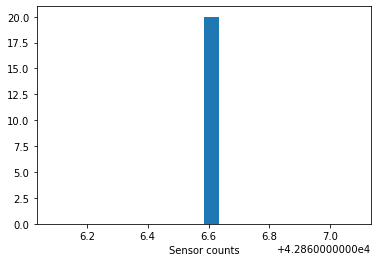

mean = 42866, sigma = 0, resolution = 0.000000


In [43]:
#fig, ax = plt.subplots()
num_bins = 20

## the histogram of the data
##n, bins, patches = ax.hist(nph_array, num_bins, density=True)
plt.hist(nph_nosat, num_bins, density=True)

# best fit of data
m, s = stats.norm.fit(nph_nosat) # get mean and standard deviation  
xmin, xmax = min(nph_nosat), max(nph_nosat)  
lnspc = np.linspace(xmin, xmax, len(nph_nosat))
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it


## Tweak spacing to prevent clipping of ylabel
##fig.tight_layout()array2d_NelGEM3

plt.xlabel('Sensor counts')
plt.ylabel('')
plt.show()

print("mean = %d, sigma = %d, resolution = %f"%(m,s,s/m))

In [67]:
## NR
z_gem = 200. #mm
z_ini = 0.

print("Opening /home/giulia/Physics/CYGNO/gain/ionization_profile_He_30keV.txt")

textfile=open("/home/giulia/Physics/CYGNO/gain/ionization_profile_He_30keV.txt")
final_imgs=list();
zvec=list(); yvec=list(); xvec=list(); evec=list()
zvec*=0; yvec*=0; xvec*=0; evec*=0
lastentry=0
nhits=0
iline=0
sumene = 0
sumeneQF = 0
content = textfile.readlines() #READ IN TXT FILE
tot_el_G2=0

histname = "histo_cloud_pic_0" 
histo_cloud = rt.TH3I(histname,"",x_pix,0,x_pix-1,y_pix,0,y_pix-1,zbins,0,zbins)

maxentries = 1
lastentry=-1

for nlines,line in enumerate(content):           #LOOP OVER LINES
    myvars=line.split()
    entry=int(myvars[0])-1
    sumene += float(myvars[5])
    sumeneQF += float(myvars[6])
    x_hit = float(myvars[2])
    y_hit = float(myvars[3])
    z_hit = float(myvars[4])
    energyDep_hit = float(myvars[5])

    if lastentry>=1:
        print("lastentry = %d, now BREAK"%lastentry) 
        break
    
    S3D = cloud_smearing3D(x_hit,y_hit,z_hit,energyDep_hit)
    for j in range(0, len(S3D[0])):
        histo_cloud.Fill((0.5*x_dim+S3D[0][j])*x_pix/x_dim, (0.5*y_dim+S3D[1][j])*y_pix/y_dim, (0.5*zcloud+S3D[2][j])*zbins/zcloud ) 
        #print((0.5*x_dim+S3D[0][j])*x_pix/x_dim, (0.5*y_dim+S3D[1][j])*y_pix/y_dim, (0.5*zcloud+S3D[2][j])*zbins/zcloud )
        tot_el_G2+=1
        #print("tot_el_G2 = %d"%tot_el_G2)
  
        if ((entry>0 and entry!=lastentry) or nlines==len(content)-1 ): #NEW EVENT FOUND (OR LAST LINE IN THE FILE) - STORE INFORMATIONS ON PREVIOUS ONE
            #tot_el_G2 = histo_cloud.Integral()
            print("tot_el_G2 = %d"%tot_el_G2)

            # 2d map of photons applying saturation effect
            result_GEM3 = Nph_saturation(histo_cloud)
            array2d_Nph = result_GEM3[1]
            tot_ph_G3 = result_GEM3[0] #np.sum(array2d_Nph)

            print("tot num of sensor counts after GEM3 including saturation: %d"%(tot_ph_G3))
            print("tot num of sensor counts after GEM3 without saturation: %d"%(A*tot_el_G2*GEM3_gain* omega * photons_per_el * counts_per_photon))
            print("Gain GEM3 = %f   Gain GEM3 saturated = %f"%(GEM3_gain, tot_ph_G3/(tot_el_G2*omega * photons_per_el * counts_per_photon) ))   
         
            zvec*=0; yvec*=0; xvec*=0; evec*=0 #RESET LISTS
            lastentry=entry #END OF THE EVENT
                
            sumene = 0.
            sumeneQF = 0.
            tot_el_G2 = 0

            histname = "histo_cloud_pic_"+str(int(entry)) 
            histo_cloud = rt.TH3I(histname,"",x_pix,0,x_pix-1,y_pix,0,y_pix-1,zbins,0,zbins)

            
        nhits=int(myvars[1])
        zvec.append(float(myvars[4]))
        yvec.append(float(myvars[3]))
        xvec.append(float(myvars[2]))
        evec.append(float(myvars[6]))
        #if iline==1:
        #    print("line: "+str(iline)+"  QF avg = "+str(float(myvars[6])/float(myvars[5])))         

        iline+=1

print('COMPLETED RUN')



Opening /home/giulia/Physics/CYGNO/gain/ionization_profile_He_30keV.txt
tot_el_G2 = 8719403
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 3

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial ele

number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel with

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 10

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial e

number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number final electrons per voxel without saturation: 7525.306813
number initial electrons per voxel input: 27
number final electrons per voxel: 8827.946724
number final electrons per voxel without saturation: 9235.603816
number initial electrons per voxel input: 35
number final electrons per voxel: 11295.901872
number final electrons per voxel without saturation: 11972.079021
number initial electrons per voxel input: 29
number final electrons per voxel: 9450.967726
number final electrons per voxel without saturation: 9919.722618
number initial electrons per voxel input: 43
number final electrons per voxel: 13700.948506
number final electrons per voxel without saturation: 14708.554226
number initial electrons per voxel input: 39
number final electrons per voxel: 12506.137457
number final electrons per voxel without saturation: 13340.316624
number initial electrons per voxel input: 34
number final electrons per voxel: 10990.897833
number final electrons per voxel without saturation: 1163

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 5
number final electrons per voxel: 16

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 7
number final electrons per voxel: 2366.088802
number final electrons per voxel without saturation: 2394.415804
number initial electrons per voxel input: 6
number final electrons per voxel: 20

number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 9
number final electrons per voxel: 3031.866082
number final electrons per voxel without saturation: 3078.534605
number initial electrons per voxel input: 11
number final electrons per voxel: 3693.172761
number final electrons per voxel without saturation: 3762.653407
number initial electrons per voxel input: 19
number final electrons per voxel: 6294.582118
number final electrons per voxel without saturation: 6499.128612
number initial electrons per voxel input: 20
number final electrons pe

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial ele

number initial electrons per voxel input: 102
number final electrons per voxel: 29707.565344
number final electrons per voxel without saturation: 34890.058862
number initial electrons per voxel input: 134
number final electrons per voxel: 37289.873899
number final electrons per voxel without saturation: 45835.959682
number initial electrons per voxel input: 185
number final electrons per voxel: 48071.066070
number final electrons per voxel without saturation: 63280.989113
number initial electrons per voxel input: 251
number final electrons per voxel: 60069.850812
number final electrons per voxel without saturation: 85856.909553
number initial electrons per voxel input: 311
number final electrons per voxel: 69443.376951
number final electrons per voxel without saturation: 106380.473589
number initial electrons per voxel input: 342
number final electrons per voxel: 73810.790925
number final electrons per voxel without saturation: 116984.315008
number initial electrons per voxel input: 45

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 7
number final electrons per voxel: 2366.088802
number final electrons per voxel without saturation: 2394.415804
number initial electrons per voxel input: 8
number final electrons per voxel: 

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number final electrons per voxel without saturation: 2736.475205
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number init

number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.

number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 11
number final electrons per voxel: 3693.172761
number final electrons per voxel without saturation: 3762.653407
number initial electrons per voxel input: 19
number final electrons per voxel: 6294.582118
number final electrons per voxel without saturation: 6499.128612
number initial electrons per voxel input: 28
number final electrons per voxel: 9139.965653
number final electrons per voxel without saturation: 9577.663217
number initial electrons per voxel input: 55
number final electrons per voxel: 17195.727927
number final electrons per voxel without saturation: 18813.267033
number initial electrons per voxel input: 86
number final electrons per voxel: 25645.086934
number final electrons per voxel without saturation: 29417.108452
number initial electrons per voxel input: 108
number final electrons per voxel: 31182.610529
number final

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial ele

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 6
number final electrons per voxel: 

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial ele

number final electrons per voxel: 3031.866082
number final electrons per voxel without saturation: 3078.534605
number initial electrons per voxel input: 8
number final electrons per voxel: 2699.539096
number final electrons per voxel without saturation: 2736.475205
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per vo

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 10

number initial electrons per voxel input: 7
number final electrons per voxel: 2366.088802
number final electrons per voxel without saturation: 2394.415804
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 8
number final electrons per voxel: 2699.539096
number final electrons per voxel without saturation: 2736.475205
number initial electrons per voxel input: 6
number final electrons per voxel: 2031.509496
number final electrons per voxel without saturation: 2052.356404
number initial electrons per voxel input: 12
number final electrons per voxel: 4022.163674
number final electrons per voxel without saturation: 4104.712807
number initial electrons per voxel input: 26
number final electrons per voxel: 8514.905945
number final electrons per voxel without saturation: 8893.544416
number initial electrons per voxel input: 33
number final electrons 

number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel with

number final electrons per voxel without saturation: 337954.687801
number initial electrons per voxel input: 752
number final electrons per voxel: 112516.421892
number final electrons per voxel without saturation: 257228.669258
number initial electrons per voxel input: 528
number final electrons per voxel: 94904.818367
number final electrons per voxel without saturation: 180607.363521
number initial electrons per voxel input: 414
number final electrons per voxel: 82908.297428
number final electrons per voxel without saturation: 141612.591852
number initial electrons per voxel input: 276
number final electrons per voxel: 64134.308878
number final electrons per voxel without saturation: 94408.394568
number initial electrons per voxel input: 172
number final electrons per voxel: 45460.926773
number final electrons per voxel without saturation: 58834.216905
number initial electrons per voxel input: 114
number final electrons per voxel: 32632.321952
number final electrons per voxel without 

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.

number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 10
number final electrons per voxel: 3363.075428
number final electrons per voxel without saturation: 3420.594006
number initial electrons per voxel input: 20
number final electrons per voxel: 6614.918506
number final electrons per voxel without saturation: 6841.188012
number initial electrons per voxel input: 32
number final electrons per voxel: 10377.922280
number final electrons per voxel without saturation: 10945.900819
number initial electrons per voxel input: 50
number final electrons

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number final electrons per voxel: 17765.483412
number final electrons per voxel without saturation: 19497.385835
number initial electrons per voxel input: 87
number final electrons per voxel: 25904.661939
number final electrons per voxel without saturation: 29759.167853
number initial electrons per voxel input: 125
number final electrons per voxel: 35226.461199
number final electrons per voxel without saturation: 42757.425076
number initial electrons per voxel input: 203
number final electrons per voxel: 51542.873160
number final electrons per voxel without saturation: 69438.058324
number initial electrons per voxel input: 248
number final electrons per voxel: 59565.715363
number final electrons per voxel without saturation: 84830.731351
number initial electrons per voxel input: 403
number final electrons per voxel: 81604.240675
number final electrons per voxel without saturation: 137849.938445
number initial electrons per voxel input: 568
number final electrons per voxel: 98551.760322

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.

number initial electrons per voxel input: 63
number final electrons per voxel: 19453.637834
number final electrons per voxel without saturation: 21549.742238
number initial electrons per voxel input: 97
number final electrons per voxel: 28458.526241
number final electrons per voxel without saturation: 33179.761859
number initial electrons per voxel input: 141
number final electrons per voxel: 38859.366338
number final electrons per voxel without saturation: 48230.375486
number initial electrons per voxel input: 200
number final electrons per voxel: 50975.299671
number final electrons per voxel without saturation: 68411.880122
number initial electrons per voxel input: 287
number final electrons per voxel: 65848.813050
number final electrons per voxel without saturation: 98171.047975
number initial electrons per voxel input: 419
number final electrons per voxel: 83491.601351
number final electrons per voxel without saturation: 143322.888855
number initial electrons per voxel input: 526
n

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial ele

number final electrons per voxel without saturation: 84488.671950
number initial electrons per voxel input: 325
number final electrons per voxel: 71452.616528
number final electrons per voxel without saturation: 111169.305198
number initial electrons per voxel input: 400
number final electrons per voxel: 81243.532312
number final electrons per voxel without saturation: 136823.760243
number initial electrons per voxel input: 464
number final electrons per voxel: 88491.037885
number final electrons per voxel without saturation: 158715.561882
number initial electrons per voxel input: 518
number final electrons per voxel: 93951.741596
number final electrons per voxel without saturation: 177186.769515
number initial electrons per voxel input: 494
number final electrons per voxel: 91592.259901
number final electrons per voxel without saturation: 168977.343901
number initial electrons per voxel input: 547
number final electrons per voxel: 96669.260751
number final electrons per voxel without 

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initi

number initial electrons per voxel input: 39
number final electrons per voxel: 12506.137457
number final electrons per voxel without saturation: 13340.316624
number initial electrons per voxel input: 41
number final electrons per voxel: 13105.452559
number final electrons per voxel without saturation: 14024.435425
number initial electrons per voxel input: 16
number final electrons per voxel: 5327.173624
number final electrons per voxel without saturation: 5472.950410
number initial electrons per voxel input: 17
number final electrons per voxel: 5650.714995
number final electrons per voxel without saturation: 5815.009810
number initial electrons per voxel input: 10
number final electrons per voxel: 3363.075428
number final electrons per voxel without saturation: 3420.594006
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electr

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number final electrons per voxel without saturation: 16418.851229
number initial electrons per voxel input: 48
number final electrons per voxel: 15173.217246
number final electrons per voxel without saturation: 16418.851229
number initial electrons per voxel input: 77
number final electrons per voxel: 23273.605907
number final electrons per voxel without saturation: 26338.573847
number initial electrons per voxel input: 100
number final electrons per voxel: 29210.138780
number final electrons per voxel without saturation: 34205.940061
number initial electrons per voxel input: 125
number final electrons per voxel: 35226.461199
number final electrons per voxel without saturation: 42757.425076
number initial electrons per voxel input: 178
number final electrons per voxel: 46676.662993
number final electrons per voxel without saturation: 60886.573308
number initial electrons per voxel input: 241
number final electrons per voxel: 58375.152917
number final electrons per voxel without saturat

number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 6
number final electrons per voxel: 2031.509496
number final electrons per voxel without saturation: 2052.356404
number initial electrons per voxel input: 7
number final electrons per voxel: 2366.088802
number final electrons per voxel without saturation: 2394.415804
number initial electrons per voxel input: 22
number final electrons per vo

number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 4
number final electrons per voxel: 

number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 13
number final electrons per voxel: 4350.053718
number final electrons per voxel without saturation: 4446.772208
number initial electrons per voxel input: 15
number final electrons per v

number initial electrons per voxel input: 14
number final electrons per voxel: 4676.848411
number final electrons per voxel without saturation: 4788.831609
number initial electrons per voxel input: 7
number final electrons per voxel: 2366.088802
number final electrons per voxel without saturation: 2394.415804
number initial electrons per voxel input: 7
number final electrons per voxel: 2366.088802
number final electrons per voxel without saturation: 2394.415804
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 7
number final electrons pe

number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 5
number final electrons per voxel: 

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 13
number final electrons per voxel: 4350.053718
number final electrons per voxel without saturation: 4446.772208
number initial electrons per voxel input: 8
number final electrons per voxe

number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel with

number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 4
number final electrons per voxel: 1358.940833
number final electrons per voxel without saturation: 1368.237602
number initial electrons per voxel input: 6
number final electrons per voxel: 2031.509496
number final electrons per voxel

number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number final electrons per voxel: 2366.088802
number final electrons per voxel without saturation: 2394.415804
number initial electrons per voxel input: 7
number final electrons per voxel: 2366.088802
number final electrons per voxel without saturation: 2394.415804
number initial electrons per voxel input: 14
number final electrons per voxel: 4676.848411
number final electrons per voxel without saturation: 4788.831609
number initial electrons per voxel input: 17
number final electrons per voxel: 5650.714995
number final electrons per voxel without saturation: 5815.009810
number initial electrons per voxel input: 19
number final electrons per voxel: 6294.582118
number final electrons per voxel without saturation: 6499.128612
number initial electrons per voxel input: 19
number final electrons per voxel: 6294.582118
number final electrons per voxel without saturation: 6499.128612
number initial electrons per voxel input: 32
number final electrons per voxel: 10377.922280
number final elect

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 7
number final electrons per voxel: 2366.088802
number final electrons per voxel without saturation: 2394.415804
number initial electrons per voxel input: 3
number final electrons per voxel: 1020.939871
number final electrons per voxel without saturation: 1026.178202
number initial electrons per voxel input: 5
number final electrons per voxel: 1695.795434
number final electrons per voxel without saturation: 1710.297003
number initial electrons per voxel input: 9
number final electrons per voxel: 3031.866082
number final electrons per voxel without saturation: 3078.534605
number initial electrons per voxel input: 9
number final electrons per voxel: 3031.866082
number final electrons per voxel without saturation: 3078.534605
numbe

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial ele

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial ele

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial ele

number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.786686
number final electrons per voxel without saturation: 684.118801
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial ele

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 2
number final electrons per voxel: 681.

number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.475376
number final electrons per voxel without saturation: 342.059401
number initial electrons per voxel input: 1
number final electrons per voxel: 341.

Warning in <TFile::Append>: Replacing existing TH1: histo_cloud_pic_0 (Potential memory leak).


created final_image


Warning in <TFile::Append>: Replacing existing TH1: pic_run1_ev1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


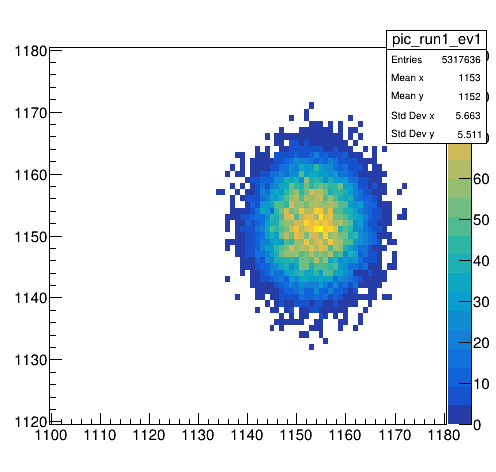

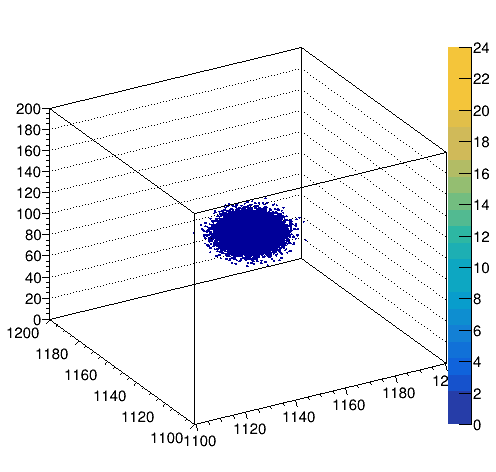

In [70]:
nph_array[iev] = tot_ph_G3
nph_nosat[iev] = tot_el_G2*GEM3_gain* omega * photons_per_el * counts_per_photon

rt.gStyle.SetCanvasPreferGL(1);

## create final image
final_image=rt.TH2I('pic_run1_ev'+str(entry), '', x_pix, 0, x_pix-1, y_pix, 0, y_pix-1)
print("created final_image")
final_image=rn.array2hist(array2d_Nph, final_image)
    
c = rt.TCanvas("c","",500,500)
final_image.GetXaxis().SetRangeUser(1100,1180)
final_image.GetYaxis().SetRangeUser(1120,1180)

final_image.Draw("colz")
c.Draw()

c2 = rt.TCanvas("c2","",500,500)
histo_cloud.GetXaxis().SetRangeUser(1100,1200)
histo_cloud.GetYaxis().SetRangeUser(1100,1200)
histo_cloud.GetZaxis().SetRangeUser(0,zbins)
hX = histo_cloud.ProjectionX()

histo_cloud.Draw("box2z")
#hX.Draw()
c2.Draw()

/home/giulia/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


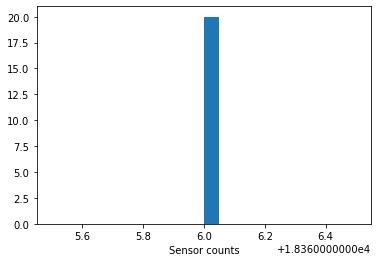

mean = 18366, sigma = 0, resolution = 0.000000


In [71]:
#fig, ax = plt.subplots()
num_bins = 20

## the histogram of the data
##n, bins, patches = ax.hist(nph_array, num_bins, density=True)
plt.hist(nph_array, num_bins, density=True)

# best fit of data
m, s = stats.norm.fit(nph_array) # get mean and standard deviation  
xmin, xmax = min(nph_array), max(nph_array)  
lnspc = np.linspace(xmin, xmax, len(nph_array))
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it


## Tweak spacing to prevent clipping of ylabel
##fig.tight_layout()array2d_NelGEM3

plt.xlabel('Sensor counts')
plt.ylabel('')
plt.show()

print("mean = %d, sigma = %d, resolution = %f"%(m,s,s/m))